In [1]:

%load_ext tensorboard

In [2]:
from PIL import Image
import io
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
from sklearn.model_selection import train_test_split
import random
import requests
import scipy as sp
import tensorflow as tf
import tensorflow.keras as keras
import zipfile
from tensorflow.keras import models
from tensorflow.keras import layers
import datetime

In [27]:
data_dir = '../projects/apple_disease_classification/data/Train'

import tensorflow as tf
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

img_height = 160
img_width = 160
batch_size = 32

In [32]:
train_ds = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                       validation_split=0.1,
                                                       subset="training",
                                                       seed=123,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)


train_label = train_ds.class_names

Found 381 files belonging to 2 classes.
Using 343 files for training.


In [33]:
val_ds = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                       validation_split=0.1,
                                                       subset="validation",
                                                       seed=123,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

val_label = val_ds.class_names


Found 381 files belonging to 2 classes.
Using 38 files for validation.


In [35]:
test_data_dir = '../projects/apple_disease_classification/data/Test'
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_data_dir, seed=123,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)
    


test_label = test_ds.class_names
print(test_label)

Found 120 files belonging to 2 classes.
['Normal_Apple', 'Reject_Apple']


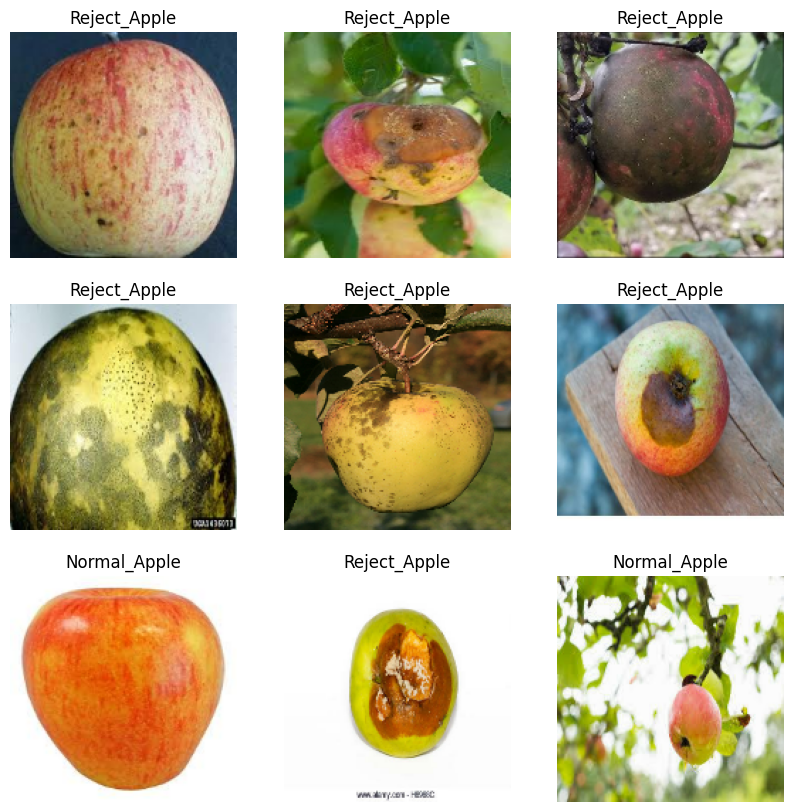

In [36]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [37]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_dataset = val_ds.take(val_batches // 5)
validation_dataset = val_ds.skip(val_batches // 5)


In [38]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_ds.prefetch(buffer_size=AUTOTUNE)
validation_dataset = val_ds.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_ds.prefetch(buffer_size=AUTOTUNE)


In [39]:
print(train_label)
print(val_label)

for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

['Normal_Apple', 'Reject_Apple']
['Normal_Apple', 'Reject_Apple']
(32, 160, 160, 3)
(32,)


In [40]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])


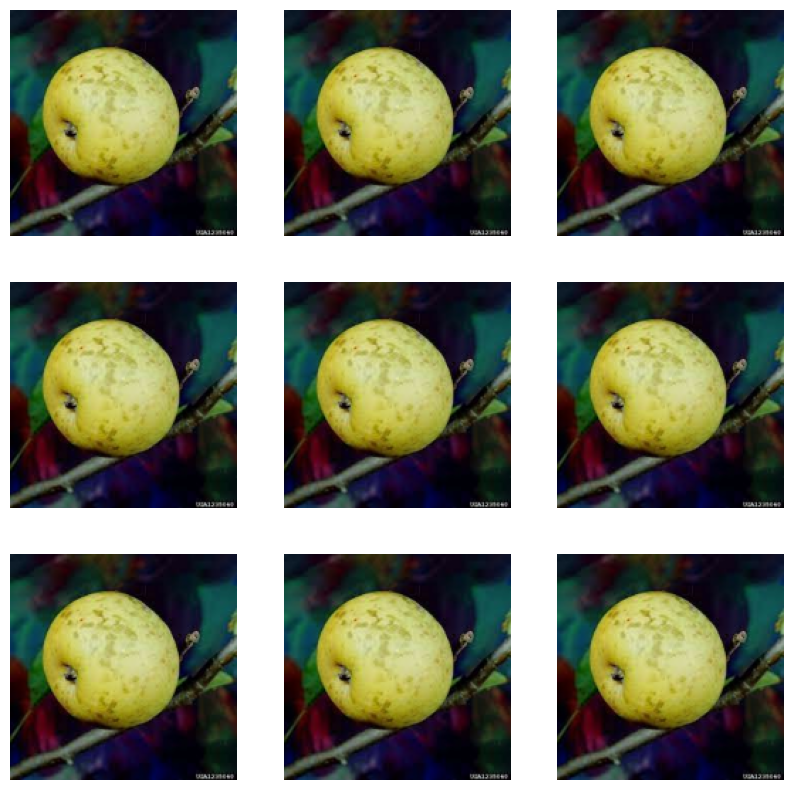

In [76]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')


In [42]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [43]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)


In [44]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SIZE = (img_height, img_width)

IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')



In [45]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)


(32, 5, 5, 1280)


In [46]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)



(32, 1280)


In [47]:
base_model.trainable = False

In [55]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)



(32, 1)


In [56]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)


In [57]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [58]:
model.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                           

In [59]:
log_dir = "logs/log" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + 'MobileNetV2'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [60]:
len(model.trainable_variables)


2

In [61]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(val_ds)


2/2 [==============================] - 2s 132ms/step - loss: 0.6289 - accuracy: 0.5263


In [62]:

history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)


print(history.history.keys())
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))


Epoch 1/10
11/11 [==============================] - 8s 464ms/step - loss: 0.6755 - accuracy: 0.5044 - val_loss: 0.5439 - val_accuracy: 0.6579
Epoch 2/10
11/11 [==============================] - 5s 437ms/step - loss: 0.5889 - accuracy: 0.5831 - val_loss: 0.4926 - val_accuracy: 0.6842
Epoch 3/10
11/11 [==============================] - 6s 499ms/step - loss: 0.5416 - accuracy: 0.6443 - val_loss: 0.4640 - val_accuracy: 0.7895
Epoch 4/10
11/11 [==============================] - 6s 485ms/step - loss: 0.4922 - accuracy: 0.6822 - val_loss: 0.4490 - val_accuracy: 0.7895
Epoch 5/10
11/11 [==============================] - 6s 495ms/step - loss: 0.4745 - accuracy: 0.7493 - val_loss: 0.4389 - val_accuracy: 0.7895
Epoch 6/10
11/11 [==============================] - 6s 498ms/step - loss: 0.4449 - accuracy: 0.7551 - val_loss: 0.4323 - val_accuracy: 0.7895
Epoch 7/10
11/11 [==============================] - 6s 507ms/step - loss: 0.4490 - accuracy: 0.7726 - val_loss: 0.4267 - val_accuracy: 0.8421
Epoch 

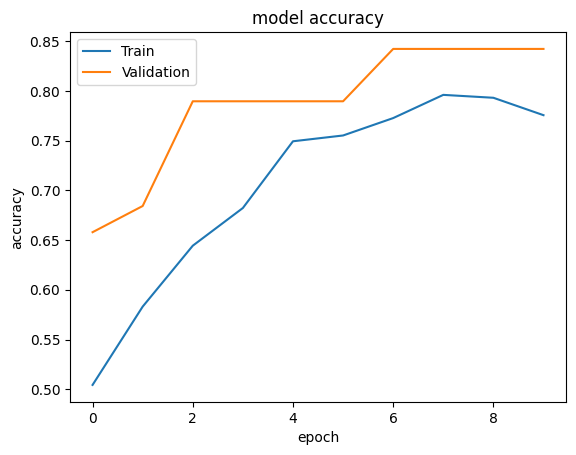

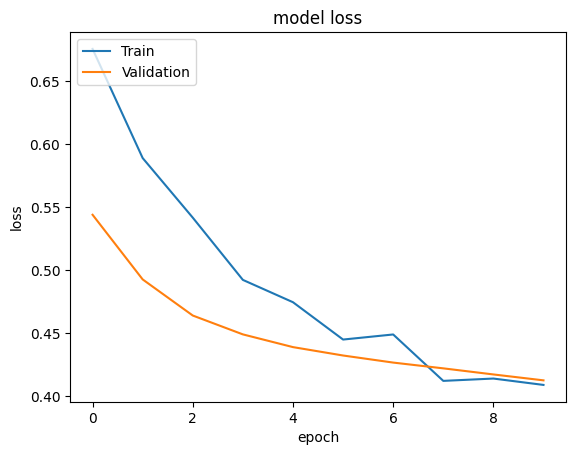

In [63]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
#plt.ylim(0,10)
plt.show()

In [64]:
#%tensorboard --logdir logs/log

In [65]:
'!kill 1464'

'!kill 1464'

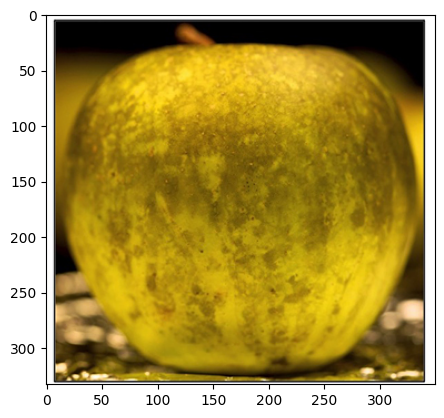

In [66]:
img = Image.open('C:/Users/Anton/MakeAIWork2/projects/apple_disease_classification/data/Use/30.jpg')


#laat plaatje zien
plt.imshow(img)

#iets met predict doen

In [67]:
img_array = tf.keras.utils.img_to_array(np.resize(img,(160,160,3)))
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.sigmoid(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


This image most likely belongs to Normal_Apple with a 45.79 percent confidence.


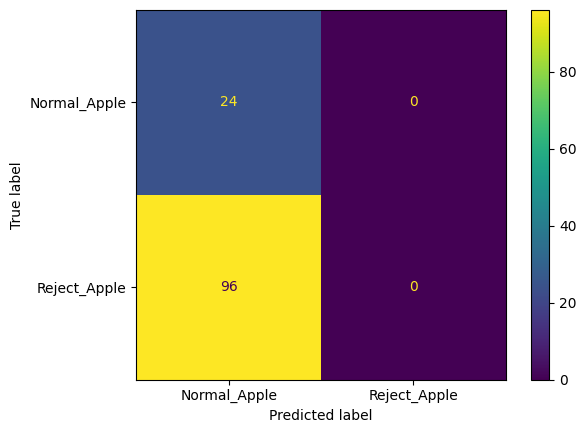

In [68]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
batchPredictions = model.predict(test_ds)
predicted_categories = tf.argmax(batchPredictions, axis=1)
true_categories = tf.concat([y for x, y in test_ds], axis=0)
# confusion_matrix(predicted_categories, true_categories)


confusion_matrix = confusion_matrix(true_categories, predicted_categories)

cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix,display_labels = ['Normal_Apple', 'Reject_Apple'])

cm_display.plot()
plt.show() 

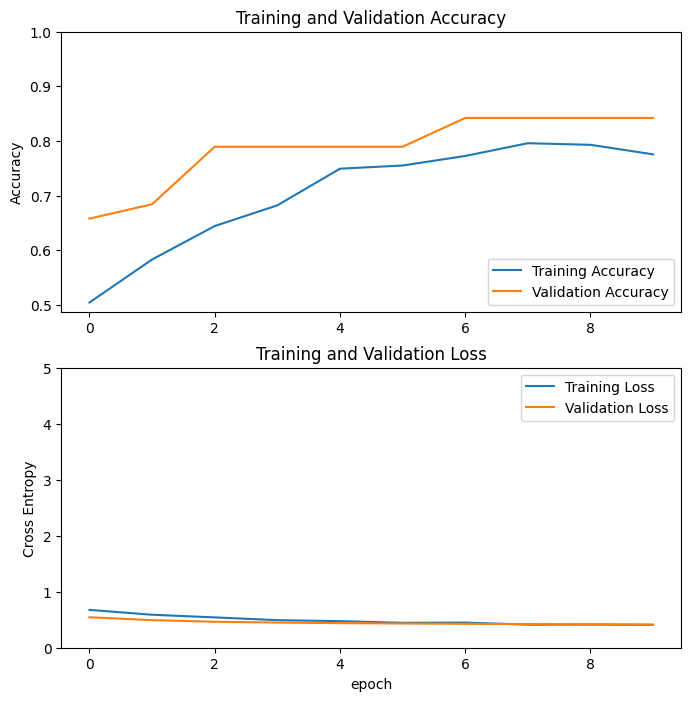

In [69]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,5.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [70]:
base_model.trainable = True


In [71]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False


Number of layers in the base model:  154


In [72]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])


In [73]:
model.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                           

In [74]:
len(model.trainable_variables)


56

In [75]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)


Epoch 10/20


InvalidArgumentError: Graph execution error:

Detected at node 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits' defined at (most recent call last):
    File "C:\Users\Anton\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\Anton\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "c:\Users\Anton\MakeAIWork2\env\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\Anton\MakeAIWork2\env\lib\site-packages\traitlets\config\application.py", line 982, in launch_instance
      app.start()
    File "c:\Users\Anton\MakeAIWork2\env\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "c:\Users\Anton\MakeAIWork2\env\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\Anton\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 600, in run_forever
      self._run_once()
    File "C:\Users\Anton\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 1896, in _run_once
      handle._run()
    File "C:\Users\Anton\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\Anton\MakeAIWork2\env\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "c:\Users\Anton\MakeAIWork2\env\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "c:\Users\Anton\MakeAIWork2\env\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "c:\Users\Anton\MakeAIWork2\env\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "c:\Users\Anton\MakeAIWork2\env\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "c:\Users\Anton\MakeAIWork2\env\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\Anton\MakeAIWork2\env\lib\site-packages\IPython\core\interactiveshell.py", line 2940, in run_cell
      result = self._run_cell(
    File "c:\Users\Anton\MakeAIWork2\env\lib\site-packages\IPython\core\interactiveshell.py", line 2995, in _run_cell
      return runner(coro)
    File "c:\Users\Anton\MakeAIWork2\env\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\Anton\MakeAIWork2\env\lib\site-packages\IPython\core\interactiveshell.py", line 3194, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\Anton\MakeAIWork2\env\lib\site-packages\IPython\core\interactiveshell.py", line 3373, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\Anton\MakeAIWork2\env\lib\site-packages\IPython\core\interactiveshell.py", line 3433, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Anton\AppData\Local\Temp\ipykernel_9808\1834500579.py", line 4, in <module>
      history_fine = model.fit(train_dataset,
    File "c:\Users\Anton\MakeAIWork2\env\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Anton\MakeAIWork2\env\lib\site-packages\keras\engine\training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\Anton\MakeAIWork2\env\lib\site-packages\keras\engine\training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "c:\Users\Anton\MakeAIWork2\env\lib\site-packages\keras\engine\training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Anton\MakeAIWork2\env\lib\site-packages\keras\engine\training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "c:\Users\Anton\MakeAIWork2\env\lib\site-packages\keras\engine\training.py", line 860, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\Anton\MakeAIWork2\env\lib\site-packages\keras\engine\training.py", line 918, in compute_loss
      return self.compiled_loss(
    File "c:\Users\Anton\MakeAIWork2\env\lib\site-packages\keras\engine\compile_utils.py", line 201, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\Anton\MakeAIWork2\env\lib\site-packages\keras\losses.py", line 141, in __call__
      losses = call_fn(y_true, y_pred)
    File "c:\Users\Anton\MakeAIWork2\env\lib\site-packages\keras\losses.py", line 245, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\Anton\MakeAIWork2\env\lib\site-packages\keras\losses.py", line 1862, in sparse_categorical_crossentropy
      return backend.sparse_categorical_crossentropy(
    File "c:\Users\Anton\MakeAIWork2\env\lib\site-packages\keras\backend.py", line 5202, in sparse_categorical_crossentropy
      res = tf.nn.sparse_softmax_cross_entropy_with_logits(
Node: 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits'
Received a label value of 1 which is outside the valid range of [0, 1).  Label values: 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_train_function_31413]

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']


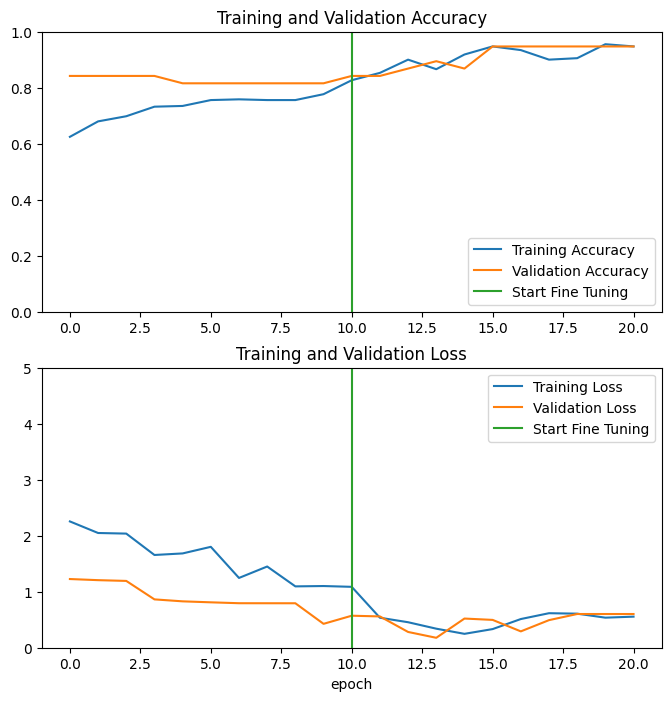

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs,initial_epochs],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 5.0])
plt.plot([initial_epochs,initial_epochs],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


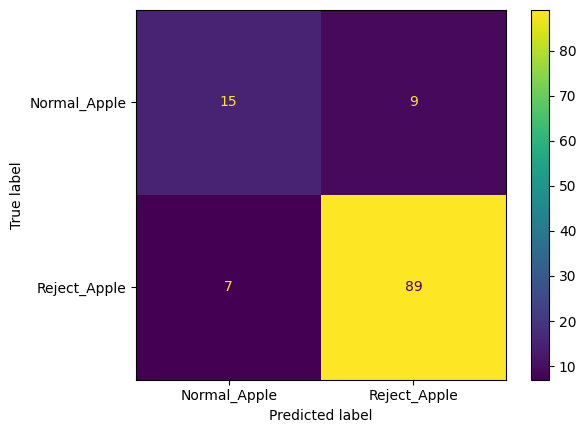

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
batchPredictions = model.predict(test_ds)
predicted_categories = tf.argmax(batchPredictions, axis=1)
true_categories = tf.concat([y for x, y in test_ds], axis=0)
# confusion_matrix(predicted_categories, true_categories)


confusion_matrix = confusion_matrix(true_categories, predicted_categories)

cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix,display_labels = ['Normal_Apple', 'Reject_Apple'])

cm_display.plot()
plt.show() 

In [ ]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)


4/4 [==============================] - 2s 548ms/step - loss: 0.7106 - accuracy: 0.8667
Test accuracy : 0.8666666746139526


Predictions:
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Labels:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]


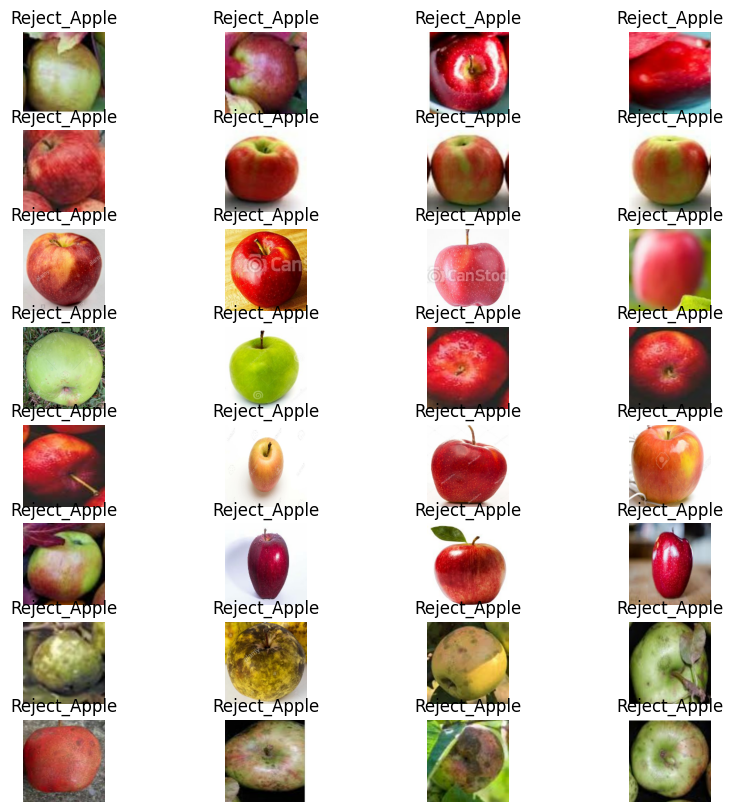

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid (softmax van gemaakt, want logits = False) since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(32):
  ax = plt.subplot(8, 4, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")


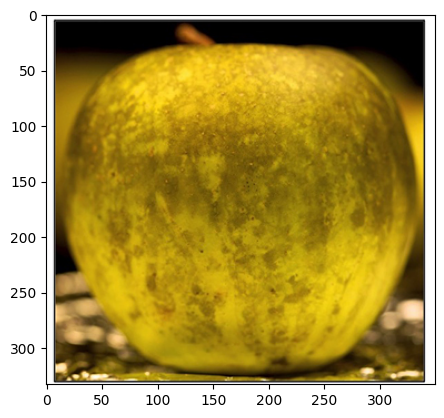

In [ ]:
img = Image.open('C:/Users/Anton/MakeAIWork2/projects/apple_disease_classification/data/Use/30.jpg')


#laat plaatje zien
plt.imshow(img)

#iets met predict doen

In [ ]:
img_array = tf.keras.utils.img_to_array(np.resize(img,(160,160,3)))
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.sigmoid(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to Reject_Apple with a 81.27 percent confidence.
